# Hit simulation of micrometeorites on Gaia

Based on Lennart Lindegren's [SAG--LL-030 technical note](http://www.astro.lu.se/~lennart/Astrometry/TN/Gaia-LL-031-20000713-Effects-of-micrometeoroids-on-GAIA-attitude.pdf).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
#values

r = 3 #m            typical impact distance from z axis - use hitDist instead
v = 12e3 #m/s       rms tangential velocity of particle
I = 7e3 #kg m^2     spacecraft moment of inertia about z axis
R = 4.25 #m         spacecraft radius

In [9]:
#Function definitions

def hitDist(hits): #distribution of micrometeorite hits across Gaia - assumed to be uniform across a disk
    theta = np.random.uniform(0,2*np.pi,hits)
    radius = np.sqrt(np.random.uniform(0,R**2,hits))
    return [(t,r) for t, r in zip(theta,radius)]


def flux(mass):    #typical flux of micrometeorites greater than mass = mass
    if mass < 2.8e-11:
        return 2.8e-11 * mass ** (-0.5)
    else:
        return 2.6e-18 * mass ** (-7.0/6.0)


def generateEvent(masses, frequencies):#create impacts according to flux for a given mass spectrum and frequency distribution
    
    #sigma_o = lambda T: 126* T**(-1.5) #uncertainty in omega for a given period, determines if hits are detectable - not used TODO implement
    #sigma_omega = [sigma_o(frequency**(-1)) for freqency in frequencies] #micro arcseconds per second
    
    distribution = [np.random.poisson(lam=frequency) for frequency in frequencies]
    impact_masses = masses[[i for i, e in enumerate(distribution) if e != 0]]
    d_omega = sum([mass * hitDist(1)[0][1] * v / I * ( 180/np.pi * 3600e3 ) for mass in impact_masses])#converts from radians to milli arcseconds 
    if d_omega:
        return d_omega
    else:
        return 0

def generateData(masses, frequencies, length, plot=False):   #return a pandas dataframe for given masses, freqencies of a given length of time
    obmt = np.arange(0, length,1)
    omega = [0]
    for t in range(length-1):
        _omega = generateEvent(masses, frequencies) #okay to pass entire mass array to generateEvent even though the last mass is neglected
        omega.append(_omega)
    df = pd.DataFrame({"OBMT" : obmt,
                       "Omega" : omega})
    if plot:
        plt.plot(obmt, omega)
        plt.xlabel("OBMT/seconds")
        plt.ylabel("Angular velocity/mas/s")
        plt.show()
        return  df[df.Omega!=0]
    else:
        return df


In [10]:
#Define the mass spectrum to be used. More masses => greater accuracy but doesn't affect hit rate
masses = np.linspace(1e-13,1e-9,1000) #kg - only masses between e-13 and e-9 need be considered - lower than e-13 have undetectable impacts, higher than e-9 have vanishingly small hit probabilities
frequencies = [100*(flux(m) - flux(m + dm)) for m, dm in zip(masses[:-1], np.diff(masses))] #per second - subtraction of the higher flux effectively bins particles

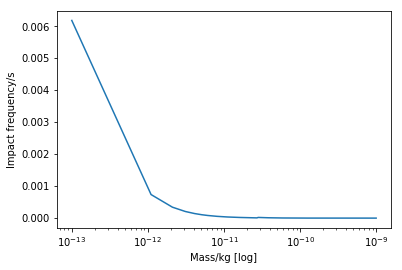

In [11]:
plt.plot(masses[:-1], frequencies) #frequencies of impact plotted versus the mass of the particles
plt.xlabel('Mass/kg [log]')
plt.ylabel('Impact frequency/s')
plt.xscale('log')
plt.show()

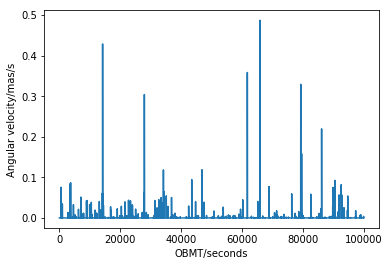

,OBMT,Omega
281,281,0.000133
299,299,0.000072
374,374,0.000054
454,454,0.000075
565,565,0.075697
629,629,0.000056
689,689,0.000127
739,739,0.000115
904,904,0.000069
999,999,0.034642


In [12]:
generateData(masses, frequencies, 100000, plot=True)